# DER系アプローチの分析用ノートブック

In [2]:
from pathlib import Path
import os, sys, json, re
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 例: 物理GPU1番だけを見せる
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

## 1) Project root / config / phase 設定

In [48]:
# === プロジェクトルートの指定 ===
# Notebook を CIDL-main の直下で開いているなら "." で OK
PROJECT_ROOT = Path("/home/kouyou/ContinualLearning/repexp/PyCIL").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from trainer import _set_device  # 既存のヘルパをそのまま使う
from utils.data_manager import DataManager
from utils import factory

# === 使いたい設定ファイルと、どの phase を可視化するか ===
CONFIG_PATH = "exps/der_mu/baseline0/cifar100.json"   # 適宜変更
PHASE_ID    = 5                                         # ex) タスク3終了時のモデル → phase3.pkl

# === json 読み込み → args にする ===
with open(CONFIG_PATH) as f:
    args = json.load(f)

# device を training と同じ形式 (list of torch.device) に変換
_set_device(args)

print("model_name:", args["model_name"])
print("dataset   :", args["dataset"])
print("device    :", args["device"])

model_name: der-mu
dataset   : cifar100
device    : [device(type='cuda', index=0)]


## 2) Checkpoint path を trainer と同じ規則で組み立てる

In [49]:
from glob import glob

def _seed_to_str(seed):
    # trainer.py は args['seed'] をそのまま format しているので、list/int 両対応にしておく
    if isinstance(seed, (list, tuple)):
        return str(seed[0]) if len(seed) else "0"
    return str(seed)

def build_ckpt_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

ckpt_dir  = build_ckpt_dir(args)
ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}.pkl"

print("ckpt_dir :", ckpt_dir)
print("ckpt_path:", ckpt_path)

# # もし exists が False のときは、pattern で探す fallback も書いておくと楽
# if not ckpt_path.exists():
#     cand = glob(str(ckpt_dir / f"phase{PHASE_ID}*.pkl"))
#     print("fallback candidates:", cand)


ckpt_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/
ckpt_path: logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32//phase_5.pkl


## 3) DataManager と model を作って checkpoint をロード（DER/TagFex など拡張系対応）

In [50]:
def infer_convnet_count_from_state_dict(state_dict):
    # keys like: 'convnets.0.xxx', 'convnets.1.xxx', ...
    idxs = []
    pat = re.compile(r"^convnets\.(\d+)\.")
    for k in state_dict.keys():
        m = pat.match(k)
        if m:
            idxs.append(int(m.group(1)))
    return (max(idxs) + 1) if idxs else 0

def classes_at_task(k, args, total_classnum):
    # task k の終了時点での total_classes（BaseLearnerの挙動に合わせる）
    init_cls = args["init_cls"]
    inc = args["increment"]
    num = init_cls + k * inc
    return min(num, total_classnum)

def build_network_skeleton_for_ckpt(model, state_dict, data_manager, args, phase_id):
    """state_dict をロード可能な形に network を拡張しておく。
    DERNet/TagFexNet 系は update_fc を task 回数ぶん呼ぶ必要がある。
    """
    net = model._network
    # DataParallel だと update_fc が面倒なので notebook では使わない前提
    if isinstance(net, torch.nn.DataParallel):
        net = net.module
        model._network = net

    convnet_count = infer_convnet_count_from_state_dict(state_dict)
    if convnet_count == 0:
        # ふつうはありえないが、念のため
        convnet_count = phase_id + 1

    # 最終クラス数は fc.weight の out_features で確定できる
    if "fc.weight" in state_dict:
        final_classes = state_dict["fc.weight"].shape[0]
    else:
        # fallback
        final_classes = classes_at_task(phase_id, args, data_manager.get_total_classnum())

    # すでに update_fc 済みのモデルなら二重に増やさない
    existing = len(getattr(net, "convnets", [])) if hasattr(net, "convnets") else 0

    # DER/TagFex 系は convnets を持つ。ここが最重要分岐。
    if hasattr(net, "update_fc") and hasattr(net, "convnets"):
        # 必要な回数だけ update_fc を呼ぶ
        # task k でのクラス数を与えながら進める（最後だけ final_classes で整合）
        total_cls = data_manager.get_total_classnum()
        for k in range(existing, convnet_count):
            nb = classes_at_task(k, args, total_cls)
            # 最後の update_fc は checkpoint の fc 次元に合わせる
            if k == convnet_count - 1:
                nb = final_classes
            net.update_fc(nb)
    else:
        # 拡張なしモデルは update_fc 1回で十分なことが多い
        if hasattr(net, "update_fc") and "fc.weight" in state_dict:
            net.update_fc(state_dict["fc.weight"].shape[0])

    return net

# --- DataManager & model ---
data_manager = DataManager(
    dataset_name=args["dataset"],
    shuffle=args.get("shuffle", True),
    seed=int(_seed_to_str(args.get("seed", 0))),
    init_cls=args["init_cls"],
    increment=args["increment"],
)

model = factory.get_model(args["model_name"], args)
model._device = args["device"][0]
model._network.to(model._device)

ckpt = torch.load(ckpt_path, map_location=model._device)
state_dict = ckpt["model_state_dict"]

# 1) skeleton を作る（update_fc を必要回数）
build_network_skeleton_for_ckpt(model, state_dict, data_manager, args, PHASE_ID)

# 2) state_dict ロード
model._network.load_state_dict(state_dict, strict=True)
model._network.to(model._device)

# 3) 追加情報（あれば）
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]
if "protos" in ckpt:
    model._protos = ckpt["protos"]

model._network.eval()
print("loaded. convnets =", len(getattr(model._network, "convnets", [])))


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-50-7c2c8aada76e>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


loaded. convnets = 6


## 4) seen / forget / retain クラス集合を作る（MU系なら forget_classes を活用）

In [51]:
# checkpoint phase 時点での「見えている」クラス数
num_classes = classes_at_task(PHASE_ID, args, data_manager.get_total_classnum())
all_seen = np.arange(num_classes)

forget_set = set(getattr(model, "forget_classes", []))
forget = np.array(sorted([c for c in forget_set if c < num_classes]), dtype=int)
retain = np.setdiff1d(all_seen, forget)

print("num_classes:", num_classes)
print("forget:", forget)
print("retain (head):", retain[:10], " ... total", len(retain))

num_classes: 60
forget: []
retain (head): [0 1 2 3 4 5 6 7 8 9]  ... total 60


## 5) 対象クラスの選択（all / forget / retain / manual）

In [52]:
TARGET_MODE = 'manual'  # 'all' / 'forget' / 'retain' / 'manual'
# MANUAL_CLASSES = [0,1,2,3,4,5,6,7,8,9]
# MANUAL_CLASSES = [10,11,12,13,14,15,16,17,18,19]
# MANUAL_CLASSES = [20,21,22,23,24,25,26,27,28,29]
# MANUAL_CLASSES = [30,31,32,33,34,35,36,37,38,39]
# MANUAL_CLASSES = [40,41,42,43,44,45,46,47,48,49]
MANUAL_CLASSES = [50,51,52,53,54,55,56,57,58,59]
# MANUAL_CLASSES = [60,61,62,63,64,65,66,67,68,69]
# MANUAL_CLASSES = [70,71,72,73,74,75,76,77,78,79]
# MANUAL_CLASSES = [80,81,82,83,84,85,86,87,88,89]
# MANUAL_CLASSES = [90,91,92,93,94,95,96,97,98,99]



if TARGET_MODE == "all":
    target_classes = all_seen
elif TARGET_MODE == "forget":
    target_classes = forget
elif TARGET_MODE == "retain":
    target_classes = retain
elif TARGET_MODE == "manual":
    target_classes = np.array(MANUAL_CLASSES, dtype=int)
else:
    raise ValueError(f"Unknown TARGET_MODE: {TARGET_MODE}")

print("TARGET_MODE:", TARGET_MODE)
print("target_classes:", target_classes[:20], " ... total", len(target_classes))


TARGET_MODE: manual
target_classes: [50 51 52 53 54 55 56 57 58 59]  ... total 10


## 6) Dataset / DataLoader（linear probe 用に train/test を用意）

In [53]:
batch_size = 128
num_workers = 8

# linear probe の学習には train mode（augmentationあり）でも良いが、
# まずは安定のため feature 抽出時は test mode（augmentationなし）を推奨。
train_dataset = data_manager.get_dataset(target_classes, source="train", mode="train")
test_dataset  = data_manager.get_dataset(target_classes, source="test",  mode="test")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

len(train_dataset), len(test_dataset)


(5000, 1000)

## 7) Backboneごとの feature 抽出（concat前）

In [54]:
def _unwrap_net(net):
    return net.module if isinstance(net, torch.nn.DataParallel) else net

def get_backbones_from_net(net):
    net = _unwrap_net(net)
    if hasattr(net, "convnets"):
        return list(net.convnets)
    raise AttributeError("This net does not have `convnets` (expected DERNet/TagFexNet-like).")

@torch.no_grad()
def extract_vectors_preconcat_by_backbone(net, loader, device):
    net = _unwrap_net(net)
    backbones = get_backbones_from_net(net)
    net.eval()
    for bb in backbones:
        bb.eval()

    feats_by_bb = [[] for _ in range(len(backbones))]
    labels_all = []

    for _, (_, x, y) in enumerate(loader):
        x = x.to(device)
        y = y.numpy()
        labels_all.append(y)

        for i, bb in enumerate(backbones):
            out = bb(x)
            f = out["features"] if isinstance(out, dict) and "features" in out else out
            feats_by_bb[i].append(f.detach().cpu().numpy())

    feats_by_bb = [np.concatenate(v, axis=0) for v in feats_by_bb]
    labels = np.concatenate(labels_all, axis=0)
    return feats_by_bb, labels

features_by_bb_train, y_train = extract_vectors_preconcat_by_backbone(model._network, train_loader, model._device)
features_by_bb_test,  y_test  = extract_vectors_preconcat_by_backbone(model._network, test_loader,  model._device)

print("num_backbones:", len(features_by_bb_train))
print("train shapes:", [f.shape for f in features_by_bb_train])
print("test  shapes:", [f.shape for f in features_by_bb_test])
print("y_train unique:", np.unique(y_train)[:20], "...")


num_backbones: 6
train shapes: [(5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64)]
test  shapes: [(1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64)]
y_train unique: [50 51 52 53 54 55 56 57 58 59] ...


## 8) 線形分類器（PyTorch）
- 入力: backbone特徴（単体 or 複数concat）
- 出力: target_classes のラベル

**注意**: `target_classes` が連番でない場合があるので、内部で `0..C-1` に re-map します。

In [55]:
def remap_labels(y, classes):
    classes = np.array(classes, dtype=int)
    idx = {c:i for i,c in enumerate(classes.tolist())}
    y2 = np.array([idx[int(t)] for t in y], dtype=int)
    return y2, idx

def standardize_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sig = X.std(axis=0, keepdims=True) + 1e-12
    return mu, sig

def standardize_apply(X, mu, sig):
    return (X - mu) / sig

def train_linear_probe(
    X_train, y_train, X_test, y_test,
    num_classes,
    epochs=30, lr=0.1, weight_decay=0.0,
    device="cuda:0",
    standardize=True,
    seed=0,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if standardize:
        mu, sig = standardize_fit(X_train)
        X_train = standardize_apply(X_train, mu, sig)
        X_test  = standardize_apply(X_test,  mu, sig)

    Xtr = torch.from_numpy(X_train).float()
    ytr = torch.from_numpy(y_train).long()
    Xte = torch.from_numpy(X_test).float()
    yte = torch.from_numpy(y_test).long()

    tr_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=512, shuffle=True)
    te_loader = DataLoader(TensorDataset(Xte, yte), batch_size=1024, shuffle=False)

    clf = torch.nn.Linear(X_train.shape[1], num_classes).to(device)
    opt = torch.optim.SGD(clf.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    for ep in range(epochs):
        clf.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = clf(xb)
            loss = F.cross_entropy(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # eval
    clf.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in te_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = clf(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    acc = 100.0 * correct / max(total, 1)
    return acc


## 9) Backboneごとの linear probe を回す（任意 subset 対応）

`BB_SETS`（backbone のインデックス集合）を自由に生成して評価します。

- `BB_SET_MODE="single+all"`: 各 backbone 単体 + 全 backbone
- `BB_SET_MODE="manual"`: 自分で `MANUAL_BB_SETS` を列挙
- `BB_SET_MODE="combinations"`: 指定サイズの組み合わせ（多すぎる場合はサンプル）
- `BB_SET_MODE="up_to_k"`: 1..K の組み合わせ（多すぎる場合はサンプル）
- `BB_SET_MODE="leave_one_out"`: 全 backbone と、各 backbone を1つずつ除外した集合

> 注: 組み合わせ全探索は指数的に増えるので、`MAX_SETS` で上限をかけています。


In [57]:
# 例:
# - 各 backbone 単体
# - 全 backbone concat
# ここを拡張して、任意の backbone subset を評価できるようにします。

B = len(features_by_bb_train)
import itertools, math

# ==== Backbone subset selection ====
# single+all    : 各 backbone 単体 + 全 backbone
# manual        : MANUAL_BB_SETS をそのまま使う
# combinations  : 指定サイズの全組み合わせ（多すぎる場合はランダムサンプル）
# up_to_k       : 1..MAX_K の組み合わせ（多すぎる場合はランダムサンプル）
# leave_one_out : 全 backbone と、各 backbone を1つずつ除外した集合
BB_SET_MODE = "manual"

# manual 用（例）
MANUAL_BB_SETS = [
                    [0,1,2,3,4,5],
                    [0,1,2,3,4],
                #   [1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8],
                #   [2, 3, 4, 5, 6, 7, 8, 9],
                #   [1, 3, 4, 5, 6, 7, 8, 9],
                #   [1, 2, 4, 5, 6, 7, 8, 9],
                #   [1, 2, 3, 5, 6, 7, 8, 9],
                #   [1, 2, 3, 4, 6, 7, 8, 9],
                #   [1, 2, 3, 4, 5, 6, 8, 9],
                #   [1, 2, 3, 4, 5, 6, 7, 9],
                #   [1, 2, 3, 4, 5, 6, 7, 8],
                #   [0, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 2, 4, 5, 6, 7, 8, 9],
                #   [0, 2, 3, 5, 6, 7, 8, 9],
                #   [0, 2, 3, 4, 6, 7, 8, 9],
                #   [0, 2, 3, 4, 5, 7, 8, 9],
                #   [0, 2, 3, 4, 5, 6, 8, 9],
                #   [0, 2, 3, 4, 5, 6, 7, 9],
                #   [0, 2, 3, 4, 5, 6, 7, 8],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                #   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                  list(range(B))]

# combinations / up_to_k 用
BB_SET_SIZES = [1]   # BB_SET_MODE="combinations" のとき有効
MAX_K = 3                  # BB_SET_MODE="up_to_k" のとき有効
MAX_SETS = 200             # 生成数の上限（爆発防止）
RANDOM_SEED = 0

def _unique_list_of_lists(sets):
    seen = set()
    out = []
    for s in sets:
        t = tuple(sorted(set(s)))
        if len(t) == 0:
            continue
        if t not in seen:
            seen.add(t)
            out.append(list(t))
    return out

def _sample_combinations(n, k, max_sets, rng):
    # comb(n,k) が大きいときに、ランダムに max_sets 個だけサンプリング
    out = set()
    tries = 0
    # 期待試行回数の暴走を防ぐ
    max_tries = max_sets * 50
    while len(out) < max_sets and tries < max_tries:
        t = tuple(sorted(rng.choice(n, size=k, replace=False).tolist()))
        out.add(t)
        tries += 1
    return [list(t) for t in sorted(out)]

def make_bb_sets(B):
    rng = np.random.default_rng(RANDOM_SEED)

    if BB_SET_MODE == "single+all":
        sets = [[i] for i in range(B)] + [list(range(B))]
        return _unique_list_of_lists(sets)

    if BB_SET_MODE == "manual":
        return _unique_list_of_lists(MANUAL_BB_SETS)

    if BB_SET_MODE == "leave_one_out":
        all_set = list(range(B))
        sets = [all_set] + [[j for j in all_set if j != i] for i in range(B)]
        return _unique_list_of_lists(sets)

    if BB_SET_MODE == "combinations":
        sets = []
        for k in BB_SET_SIZES:
            # 全列挙できるかの粗い判定
            # まずは小さいなら全列挙、デカいならサンプリング
            try:
                # comb が大きすぎると float になるので int 化注意
                total = math.comb(B, k)
            except Exception:
                total = MAX_SETS + 1
            if total <= MAX_SETS:
                sets += [list(c) for c in itertools.combinations(range(B), k)]
            else:
                sets += _sample_combinations(B, k, MAX_SETS, rng)
        # 生成上限でカット
        return _unique_list_of_lists(sets)[:MAX_SETS]

    if BB_SET_MODE == "up_to_k":
        sets = []
        for k in range(1, min(MAX_K, B) + 1):
            try:
                total = math.comb(B, k)
            except Exception:
                total = MAX_SETS + 1
            if total <= (MAX_SETS // max(1, min(MAX_K, B))):
                sets += [list(c) for c in itertools.combinations(range(B), k)]
            else:
                # kごとに上限を分配してサンプル
                per_k = max(1, MAX_SETS // max(1, min(MAX_K, B)))
                sets += _sample_combinations(B, k, per_k, rng)
        return _unique_list_of_lists(sets)[:MAX_SETS]

    raise ValueError(f"Unknown BB_SET_MODE: {BB_SET_MODE}")

BB_SETS = make_bb_sets(B)
print("BB_SET_MODE:", BB_SET_MODE)
print("num BB_SETS:", len(BB_SETS))
print("examples   :", BB_SETS[:10])

def concat_bbs(features_by_bb, bb_ids):
    return np.concatenate([features_by_bb[i] for i in bb_ids], axis=1)

# target_classes に合わせてラベルを 0..C-1 に remap
ytr_map, _ = remap_labels(y_train, target_classes)
yte_map, _ = remap_labels(y_test, target_classes)

rows = []
for bb_ids in BB_SETS:
    Xtr = concat_bbs(features_by_bb_train, bb_ids)
    Xte = concat_bbs(features_by_bb_test,  bb_ids)

    acc = train_linear_probe(
        Xtr, ytr_map, Xte, yte_map,
        num_classes=len(target_classes),
        epochs=30, lr=0.05, weight_decay=0.9,
        device=str(model._device),
        # standardize=True,
        standardize=False,
        seed=0,
    )
    rows.append({
        "bb_ids": str(bb_ids),
        "size": len(bb_ids),
        "dim": Xtr.shape[1],
        "acc_all(%)": acc,
    })

df_res = pd.DataFrame(rows).sort_values(["acc_all(%)", "size"], ascending=[False, True]).reset_index(drop=True)
df_res


BB_SET_MODE: manual
num BB_SETS: 2
examples   : [[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4]]


,bb_ids,size,dim,acc_all(%)
0,"[0, 1, 2, 3, 4, 5]",6,384,86.3
1,"[0, 1, 2, 3, 4]",5,320,58.9


In [26]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)   # 列も全部見たいなら
pd.set_option("display.width", 0)            # 折り返し調整（環境による）


## 10) forget / retain 別の精度も出す（可能なら）
`TARGET_MODE='all'` で target_classes が seen 全体のときに一番意味が出ます。

In [27]:
def split_mask(y, subset):
    s = set(np.array(subset, dtype=int).tolist())
    return np.array([int(t) in s for t in y], dtype=bool)

if len(forget) > 0 and TARGET_MODE == "all":
    forget_mask_te = split_mask(y_test, forget)
    retain_mask_te = split_mask(y_test, retain)

    rows = []
    for bb_ids in BB_SETS:
        Xtr = concat_bbs(features_by_bb_train, bb_ids)
        Xte = concat_bbs(features_by_bb_test,  bb_ids)

        # train on all seen (audit目的)
        acc_all = train_linear_probe(
            Xtr, ytr_map, Xte, yte_map,
            num_classes=len(target_classes),
            epochs=30, lr=0.1, weight_decay=0.0,
            device=str(model._device),
            standardize=True,
            seed=0,
        )

        # evaluate on subsets by filtering test set
        Xte_f = Xte[forget_mask_te]
        yte_f, _ = remap_labels(y_test[forget_mask_te], target_classes)

        Xte_r = Xte[retain_mask_te]
        yte_r, _ = remap_labels(y_test[retain_mask_te], target_classes)

        acc_forget = train_linear_probe(
            Xtr, ytr_map, Xte_f, yte_f,
            num_classes=len(target_classes),
            epochs=30, lr=0.005, weight_decay=0.0,
            device=str(model._device),
            standardize=True,
            seed=0,
        )
        acc_retain = train_linear_probe(
            Xtr, ytr_map, Xte_r, yte_r,
            num_classes=len(target_classes),
            epochs=30, lr=0.1, weight_decay=0.0,
            device=str(model._device),
            standardize=True,
            seed=0,
        )
        rows.append({
            "bb_ids": str(bb_ids),
            "dim": Xtr.shape[1],
            "acc_all(%)": acc_all,
            "acc_forget(%)": acc_forget,
            "acc_retain(%)": acc_retain,
        })

    df_split = pd.DataFrame(rows)
    df_split
else:
    print("forget が空 or TARGET_MODE != 'all' なので skip")


forget が空 or TARGET_MODE != 'all' なので skip


## 11) 可視化（bar）

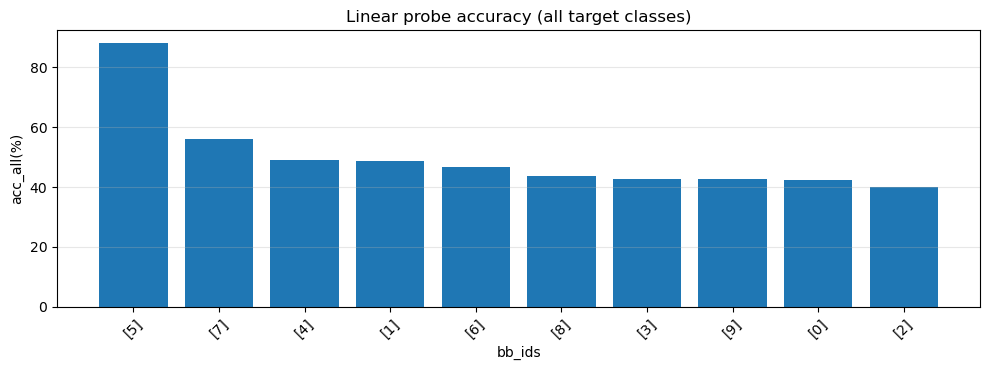

In [28]:
def barplot(df, xcol="bb_ids", ycol="acc_all(%)", title=None):
    fig, ax = plt.subplots(figsize=(10, 3.8))
    ax.bar(df[xcol].values, df[ycol].values)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_title(title or ycol)
    ax.grid(True, alpha=0.3, axis="y")
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

barplot(df_res, ycol="acc_all(%)", title="Linear probe accuracy (all target classes)")


## 12) Backbone寄与率の分析（DERのlogit分解）

DER系は（典型的には）**concat特徴 → 線形分類器** なので、

\[
z(x) = W [f^{(0)}(x);\dots;f^{(B-1)}(x)] + b
\]

と書けます。`W` を backbone ブロックごとに分割すれば、**各 backbone が logit に与える寄与**を分解できます。

ここでは、サンプルごとに

- 寄与: 選んだクラス（`true` or `pred`）の logit への各 backbone ブロックの内積
- 寄与率: \(|\text{寄与}_b| / \sum_b |\text{寄与}_b|\)

を計算し、平均して **backbone の寄与率**を出します。


In [46]:
import numpy as np
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt

def _unwrap_net2(net):
    return net.module if isinstance(net, torch.nn.DataParallel) else net

def _get_weight_2d(m):
    w = getattr(m, "weight", None)
    if w is None:
        return None
    if torch.is_tensor(w) and w.ndim == 2:
        return w
    return None

def find_concat_classifier(net, in_features_total: int):
    # DER系で concat 特徴 (sum dims) を入力に取る最終分類層を見つける。
    # nn.Linear に限らず、PyCIL の SimpleLinear / CosineLinear など weight を持つ層も対象。
    net = _unwrap_net2(net)

    # まず典型の属性名を優先（DERNet系は fc が多い）
    pri_names = ["fc", "classifier", "head", "linear"]
    for name in pri_names:
        if hasattr(net, name):
            m = getattr(net, name)
            w = _get_weight_2d(m)
            if w is not None and (w.shape[1] == in_features_total or w.shape[0] == in_features_total):
                # print(m)
                # assert False
                return m

    candidates = []
    shapes = []
    for n, m in net.named_modules():
        w = _get_weight_2d(m)
        if w is None:
            continue
        shapes.append((n, tuple(w.shape)))
        if (w.shape[1] == in_features_total) or (w.shape[0] == in_features_total):
            candidates.append((n, m, w))

    if len(candidates) == 0:
        msg = (f"concat classifier が見つかりません (in_total={in_features_total}).\n"
               f"Linear-like weight shape 候補（先頭10件）: {shapes[:10]}\n"
               f"対処: 1) net.fc 等の分類層名を確認, 2) in_total が正しいか確認")
        raise RuntimeError(msg)

    # 'fc' / 'classifier' / 'head' を優先
    def score(name):
        s = 0
        if re.search(r"(^|\.)fc($|\.)", name): s += 5
        if "classifier" in name: s += 3
        if "head" in name: s += 2
        if "aux" in name: s -= 2
        return s

    candidates.sort(key=lambda x: (-score(x[0]), x[0]))
    # print(candidates)
    # assert False
    return candidates[0][1]

def split_classifier_weight_by_backbone(W_2d: torch.Tensor, dims):
    # W: (out_features, in_total) の想定。backboneごとに列方向で分割して返す。
    blocks = []
    s = 0
    for d in dims:
        d = int(d)
        blocks.append(W_2d[:, s:s+d])
        s += d
    assert s == W_2d.shape[1], f"split mismatch: sum(dims)={s}, W.shape[1]={W_2d.shape[1]}"
    return blocks

def backbone_contribution_rates(features_by_bb, y, clf, class_mode="true", eps=1e-12):
    # features_by_bb: list of np.ndarray, each (N, dim_b)  (concat前特徴)
    # y: np.ndarray (N,)
    # clf: 最終分類層（weightを持つ Linear-like layer）
    # class_mode: "true" or "pred"
    dims = [f.shape[1] for f in features_by_bb]
    in_total = int(np.sum(dims))

    W = _get_weight_2d(clf).detach().cpu()
    # 一部実装で (in_total, out) の場合があるので補正
    if W.shape[1] != in_total and W.shape[0] == in_total:
        W = W.t().contiguous()
    if W.shape[1] != in_total:
        raise RuntimeError(f"classifier weight shape mismatch: W={tuple(W.shape)}, in_total={in_total}")

    b = getattr(clf, "bias", None)
    if b is not None and torch.is_tensor(b):
        b = b.detach().cpu().numpy()
    else:
        b = None

    W_blocks = split_classifier_weight_by_backbone(W, dims)

    # concat logits を作って pred を取る（class_mode='pred' のため）
    X_concat = np.concatenate(features_by_bb, axis=1).astype(np.float32)  # (N, in_total)
    logits = X_concat @ W.numpy().T  # (N, C)
    if b is not None:
        logits = logits + b.reshape(1, -1)
    pred = logits.argmax(axis=1).astype(np.int64)

    if class_mode == "true":
        k_idx = y.astype(np.int64)
    elif class_mode == "pred":
        k_idx = pred
    else:
        raise ValueError("class_mode must be 'true' or 'pred'")

    N = X_concat.shape[0]
    B = len(dims)

    contrib = np.zeros((N, B), dtype=np.float32)
    for bi, (F_b, W_b) in enumerate(zip(features_by_bb, W_blocks)):
        # W_b: (C, d), F_b: (N, d)
        Wb = W_b.numpy().astype(np.float32)
        wb_rows = Wb[k_idx]  # (N, d)
        contrib[:, bi] = (wb_rows * F_b.astype(np.float32)).sum(axis=1)

    abs_contrib = np.abs(contrib)
    denom = abs_contrib.sum(axis=1, keepdims=True)
    rates = abs_contrib / np.maximum(denom, eps)

    return {
        "contrib": contrib,
        "rates": rates,
        "mean_abs_contrib": abs_contrib.mean(axis=0),
        "mean_rate": rates.mean(axis=0),
        "dims": dims,
        "pred": pred,
        "logits": logits,
    }


In [ ]:
# ここまでで features_by_bb_test, y_test, model は既に作られている前提（元ノートブックのセルを実行済み）
net = _unwrap_net2(model._network)

dims = [f.shape[1] for f in features_by_bb_test]
in_total = int(np.sum(dims))

clf = find_concat_classifier(net, in_features_total=in_total)
W = _get_weight_2d(clf).detach().cpu()
if W.shape[1] != in_total and W.shape[0] == in_total:
    # print("W.shape: ", W.shape)
    W = W.t().contiguous()

print("found classifier:", type(clf))
print("W.shape:", tuple(W.shape), " | in_total:", in_total, " | num_backbones:", len(dims))
print("dims:", dims)

# 寄与率（true label / pred）を計算
out_true = backbone_contribution_rates(features_by_bb_test, y_test, clf, class_mode="true")
out_pred = backbone_contribution_rates(features_by_bb_test, y_test, clf, class_mode="pred")

df_contrib = pd.DataFrame({
    "bb_id": np.arange(len(dims), dtype=int),
    "dim": dims,
    "mean_abs_contrib(true)": out_true["mean_abs_contrib"],
    "mean_rate(true)": out_true["mean_rate"],
    "mean_abs_contrib(pred)": out_pred["mean_abs_contrib"],
    "mean_rate(pred)": out_pred["mean_rate"],
}).sort_values("mean_rate(true)", ascending=False).reset_index(drop=True)

df_contrib


W.shape:  torch.Size([100, 640])


AssertionError: 

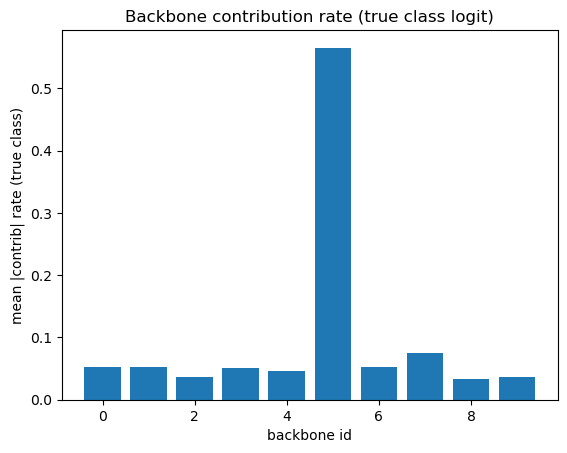

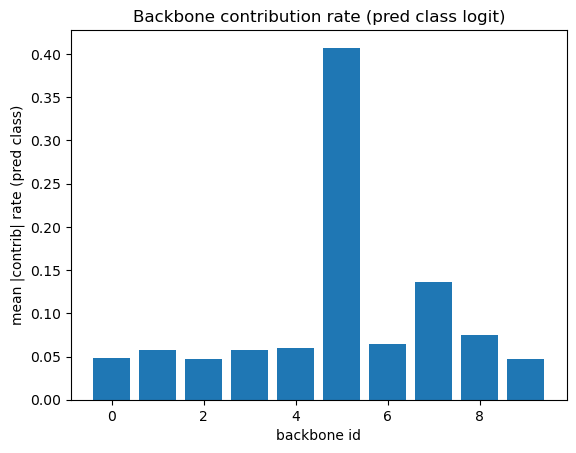

In [38]:
# 可視化（寄与率）
plt.figure()
plt.bar(df_contrib["bb_id"].astype(int), df_contrib["mean_rate(true)"].astype(float))
plt.xlabel("backbone id")
plt.ylabel("mean |contrib| rate (true class)")
plt.title("Backbone contribution rate (true class logit)")
plt.show()

plt.figure()
plt.bar(df_contrib["bb_id"].astype(int), df_contrib["mean_rate(pred)"].astype(float))
plt.xlabel("backbone id")
plt.ylabel("mean |contrib| rate (pred class)")
plt.title("Backbone contribution rate (pred class logit)")
plt.show()
